In [2]:
! pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 18.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
from PIL import Image
import cv2

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! kaggle datasets download -d christianvorhemus/industrial-quality-control-of-packages

 97% 225M/232M [00:03<00:00, 90.6MB/s]
100% 232M/232M [00:03<00:00, 79.2MB/s]


In [6]:
!unzip /content/industrial-quality-control-of-packages.zip

Archive:  /content/industrial-quality-control-of-packages.zip
  inflating: damaged/side/0101069901524_side.png  
  inflating: damaged/side/0105413725474_side.png  
  inflating: damaged/side/0109451226527_side.png  
  inflating: damaged/side/0111632059302_side.png  
  inflating: damaged/side/0118055224146_side.png  
  inflating: damaged/side/0120928945494_side.png  
  inflating: damaged/side/0122691608037_side.png  
  inflating: damaged/side/0123374171704_side.png  
  inflating: damaged/side/0129768769736_side.png  
  inflating: damaged/side/0163723873967_side.png  
  inflating: damaged/side/0185507921789_side.png  
  inflating: damaged/side/0185973818825_side.png  
  inflating: damaged/side/0188055850357_side.png  
  inflating: damaged/side/0197052530143_side.png  
  inflating: damaged/side/0198998397732_side.png  
  inflating: damaged/side/0205031618492_side.png  
  inflating: damaged/side/0205275090120_side.png  
  inflating: damaged/side/0214448761111_side.png  
  inflating: damaged

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import os

# Define the paths to the directories containing the data
damaged_path = '/content/damaged/'
intact_path = '/content/intact/'

# Create empty lists to store the images and labels
x_data = []
y_data = []

# Define the data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Loop through the 'damaged' and 'intact' folders
for label, path in [('damaged', damaged_path), ('intact', intact_path)]:
        for i in range(0, 100):
             # Load the 'side' and 'top' views of the package
             file = sorted(os.listdir(path + "side"))
             img_side = np.asarray(Image.open(path + 'side/' + file[i]).resize((300, 300)))
             file = sorted(os.listdir(path + "top"))
             img_top = np.asarray(Image.open(path + 'top/' + file[i]).resize((300, 300)))
             # Concatenate the 'side' and 'top' views into a single image
             img = np.concatenate((img_side, img_top), axis=1)
             # Apply data augmentation
             img_gen = datagen.random_transform(img)
             # Add the image to the input data
             x_data.append(img_gen)
             # Add the label to the output data
             y_data.append(label)

# Convert the input and output data to numpy arrays
x_data = np.asarray(x_data)
y_data = np.asarray(y_data).reshape(-1, 1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


In [42]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
type(x_train)

x_train shape: (160, 300, 600, 3) - y_train shape: (160, 1)
x_test shape: (40, 300, 600, 3) - y_test shape: (40, 1)


numpy.ndarray

['intact']


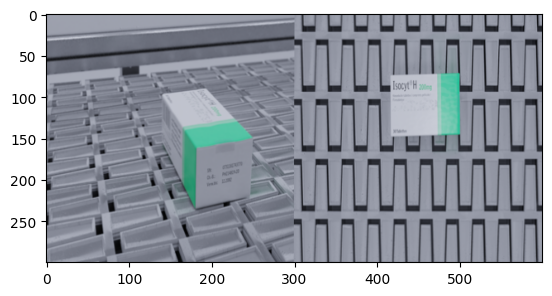

['damaged']


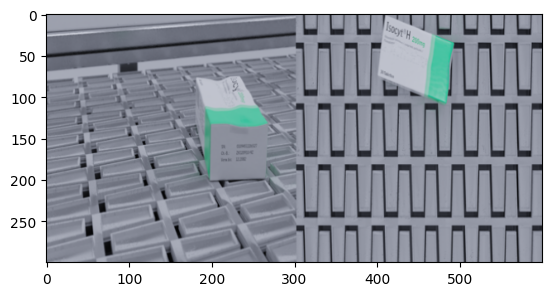

In [43]:
print(y_train[90])
plt.imshow(x_train[90])
plt.show()
print(y_train[40])
plt.imshow(x_train[40])
plt.show()

In [44]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train) 
y_test = lb.fit_transform(y_test) 

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
num_classes = 2
input_shape = (300, 600, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [47]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [48]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [49]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


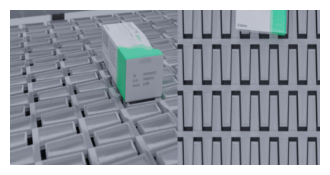

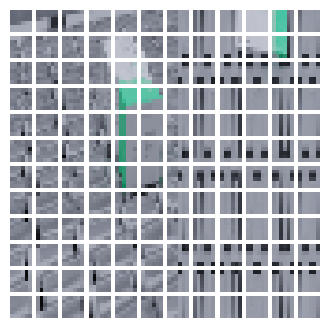

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [51]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [52]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [53]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 29s 29s/step - loss: 1.6580 - accuracy: 0.5139 - top-5-accuracy: 1.0000 - val_loss: 4.8511 - val_accuracy: 0.5625 - val_top-5-accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 18s 18s/step - loss: 7.3867 - accuracy: 0.5000 - top-5-accuracy: 1.0000 - val_loss: 6.2394 - val_accuracy: 0.4375 - val_top-5-accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 15s 15s/step - loss: 7.4771 - accuracy: 0.5000 - top-5-accuracy: 1.0000 - val_loss: 1.0823 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 1.7795 - accuracy: 0.4792 - top-5-accuracy: 1.0000 - val_loss: 1.4464 - val_accuracy: 0.5625 - val_top-5-accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 11s 11s/step - loss: 1.7618 - accuracy: 0.5208 - top-5-accuracy: 1.0000 - val_loss: 1.6713 - val_accuracy: 0.4375 - val_top-5-accuracy: 1.0000
Epoch 6/100
1/1 [=============